In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


df = pd.read_csv('poetry.csv')
df = df.drop(columns=df.columns[[5, 6, 7, 8]], axis=1)

df = df[:]

def get_century_roman(year):
	century = year // 100 + 1
	roman_numerals = {
		1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V',
		6: 'VI', 7: 'VII', 8: 'VIII', 9: 'IX', 10: 'X',
		11: 'XI', 12: 'XII', 13: 'XIII', 14: 'XIV', 15: 'XV',
		16: 'XVI', 17: 'XVII', 18: 'XVIII', 19: 'XIX', 20: 'XX', 21: 'XXI'
	}
	return roman_numerals[century]

def proc_row(row):	
	#text = '\n'.join(row['text'].split('\n')[:4])
	text = row['text'].replace('\r', '')

	line_count = text.count('\n') + 1
	word_count = text.count(' ') + line_count

	name = row['name'] if not pd.isna(row['name']) else row['text'].split('\n')[0] + '...'
	author = row['author'] if not pd.isna(row['author']) else 'неизвестен'

	date_from, date_to = row['date_from'], row['date_to']
	date = -1
	if not pd.isna(date_to): date = date_to
	elif not pd.isna(date_from): date = date_from

	century = ''
	epoch = ''
	if date != -1:
		century = f'{get_century_roman(date)} ({int(date//100+1)})'
		if date < 1500: epoch = 'древнерусская поэзия'
		if 1750 <= date < 1850: epoch = 'золотой век'
		if 1850 <= date < 1900: epoch = 'реализм и натурализм восемнадцатого века'
		if 1900 <= date < 1950: epoch = 'серебряный век, авангард'
		if 1950 <= date < 1990: epoch = 'советский период'
		if 1990 <= date < 2010: epoch = 'бронзовый век'
		if 2010 <= date < 2100: epoch = 'современная поэзия'


	return pd.Series({'author': author, 'name': name, 'text': text, 
				   	  'date': int(date), 'century': century, 'epoch': epoch, 
				  	  'line_count': line_count, 'word_count': word_count})

df = df.apply(proc_row, axis=1)

df.head()

,author,name,text,date,century,epoch,line_count,word_count
0,Михаил Лермонтов,Забывши волнения жизни мятежной...,"Забывши волнения жизни мятежной,\nОдин жил в п...",1829,XIX (19),золотой век,8,30
1,Сергей Есенин,"Нивы сжаты, рощи голы...","Нивы сжаты, рощи голы,\nОт воды туман и сырост...",1918,XX (20),"серебряный век, авангард",12,47
2,Игорь Северянин,ЧАРЫ ЛЮЧИНЬ,Лючинь печальная читала вечером ручьисто-вкрад...,1919,XX (20),"серебряный век, авангард",12,86
3,Анатолий Жигулин,Золото,"Глыбу кварца разбили молотом,\nИ, веселым огне...",1963,XX (20),советский период,30,123
4,Николай Тихонов,Хоровод в Сульдуси,"Хлынул дождь, когда девушки, встав в хоровод,\...",1940,XX (20),"серебряный век, авангард",16,93


In [24]:
len(df)

16694

In [25]:
from sentence_transformers import SentenceTransformer
import math

import torch
torch.cuda.empty_cache()

from tqdm import tqdm
tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2', device=device)
#model = SentenceTransformer('sentence-transformers/LaBSE', device=device)

def to_embeddings(input_text):
    tokens_count = model.tokenize(input_text)['input_ids'].shape[0]
    chunks_n = math.ceil(tokens_count / model.max_seq_length)

    step = math.ceil(len(input_text) / chunks_n)

    text_chunks = [input_text[i:i+step] for i in range(0, len(input_text), step)]
    
    embeddings = model.encode(text_chunks)
    return embeddings


Using device: cuda


In [26]:
def add_embedding_to_row(row):
	metadata = ''
	metadata += f'объем: количество строк {row["line_count"]}, '
	metadata += f'количество четверостиший: {int(row["line_count"]//4)}, '
	metadata += f'количество слов: {row["word_count"]}; '

	if row['author'] != 'неизвестен': metadata += f'автор: {row["author"]}; '

	if row['date'] != -1:
		metadata += f'временной период: {row["century"]} век, {row["date"]} год, '

	if len(row['epoch']) > 0: metadata += row['epoch'] 

	row['text_embedding'] = to_embeddings(row['name'] + '\n\n' + row['text'])
	row['metadata_embedding'] = to_embeddings(metadata)[0]

	return pd.Series(row)

df = df.progress_apply(add_embedding_to_row, axis=1)


100%|██████████| 16694/16694 [23:05<00:00, 12.05it/s]


In [27]:
df.to_pickle('poetry_data_prepared_distiluse.pkl')

In [28]:
import pandas as pd

df = pd.read_pickle('poetry_data_prepared_distiluse.pkl')
df.head()

,author,name,text,date,century,epoch,line_count,word_count,text_embedding,metadata_embedding
0,Михаил Лермонтов,Забывши волнения жизни мятежной...,"Забывши волнения жизни мятежной,\nОдин жил в п...",1829,XIX (19),золотой век,8,30,"[[-0.0060088797, 0.0023857844, -0.02221782, -0...","[0.05686018, 0.01054107, 0.0054414314, 0.00180..."
1,Сергей Есенин,"Нивы сжаты, рощи голы...","Нивы сжаты, рощи голы,\nОт воды туман и сырост...",1918,XX (20),"серебряный век, авангард",12,47,"[[-0.0103182765, -0.00081915647, -0.0445289, -...","[0.06642261, -0.015658984, -0.015394135, -0.02..."
2,Игорь Северянин,ЧАРЫ ЛЮЧИНЬ,Лючинь печальная читала вечером ручьисто-вкрад...,1919,XX (20),"серебряный век, авангард",12,86,"[[-0.015138468, -0.004268595, 0.005018465, -0....","[0.06060445, -0.03000408, -0.007322233, -0.017..."
3,Анатолий Жигулин,Золото,"Глыбу кварца разбили молотом,\nИ, веселым огне...",1963,XX (20),советский период,30,123,"[[-0.013852592, 0.009750016, 0.018812772, -0.0...","[0.059865776, 0.020784905, 0.012353897, -0.010..."
4,Николай Тихонов,Хоровод в Сульдуси,"Хлынул дождь, когда девушки, встав в хоровод,\...",1940,XX (20),"серебряный век, авангард",16,93,"[[0.014695941, 0.04887105, -0.0035296625, -0.0...","[0.057123616, -0.006725339, -0.017112186, -0.0..."


In [30]:
from transformers import pipeline
from pymorphy2 import MorphAnalyzer
import re

qa_model = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

def get_normal_sentence(text):
	morph = MorphAnalyzer()
	words = re.findall(r'\b\w+\b', text.lower())
	lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
	return ' '.join(lemmatized_words)

def extract_metadata(request):
	r = qa_model(question=[
		# 'упомянутое количество строк или четверостиший или слов', 
		# 'упомянутое авторство', 
		# 'упомянутая эпоха или упомянутый век или год'
		'Какой объем?', 
		'Кто авторы или автор или упомянут?', 
		'Какой век или год или эпоха?'
		], context=get_normal_sentence(request)) 
	
	rs = ['length', 'author', 'date']

	return {rs[i]: r[i] for i in range(len(rs))}


def to_standard(data):
	r = ''
	if data['length']['score'] > 0.01: r += f'объем: {get_normal_sentence(data['length']['answer'])}; '
	if data['author']['score'] > 0.01: r += f'автор: {get_normal_sentence(data['author']['answer'])}; '
	if data['date']['score'] > 0.01: r += f'временной период: {get_normal_sentence(data['date']['answer'])}'
	return r


request = 'поэзия, поэт, творчество, искусство, объемом 15 строчек, эпохи серебряного века'

print(get_normal_sentence(request))
print(extract_metadata(request))
print(to_standard(extract_metadata(request)))

поэзия поэт творчество искусство объём 15 строчка эпоха серебряный век
{'length': {'score': 0.5047397017478943, 'start': 38, 'end': 49, 'answer': ' 15 строчка'}, 'author': {'score': 0.037136007100343704, 'start': 6, 'end': 11, 'answer': ' поэт'}, 'date': {'score': 0.3010312020778656, 'start': 55, 'end': 70, 'answer': ' серебряный век'}}
объем: 15 строчка; автор: поэт; временной период: серебряный век


{'length': {'score': 0.00014194377581588924, 'start': 0, 'end': 18, 'answer': 'снова я напиваться'}, 'author': {'score': 8.572729939260171e-07, 'start': 0, 'end': 7, 'answer': 'снова я'}, 'date': {'score': 1.4022945833858103e-05, 'start': 0, 'end': 18, 'answer': 'снова я напиваться'}}
 
Я пригвожден к трактирной стойке.
Я пьян давно. Мне всё - равно.
Вон счастие мое - на тройке
В сребристый дым унесено...
Летит на тройке, потонуло
В снегу времен, в дали веков...
И только душу захлестнуло
Сребристой мглой из-под подков...
В глухую темень искры мечет,
От искр всю ночь, всю ночь светло...
Бубенчик под дугой лепечет
О том, что счастие прошло...
И только сбруя золотая
Всю ночь видна... Всю ночь слышна...
А ты, душа... душа глухая...
Пьяным пьяна... пьяным пьяна...
{'score': array([0.5462536], dtype=float32), 'text_sim': array([0.5462536], dtype=float32), 'req_sim': array([-0.01267456], dtype=float32), 'author': 'Александр Блок', 'name': 'Я пригвожден к трактирной стойке...', 'date': 1908, '

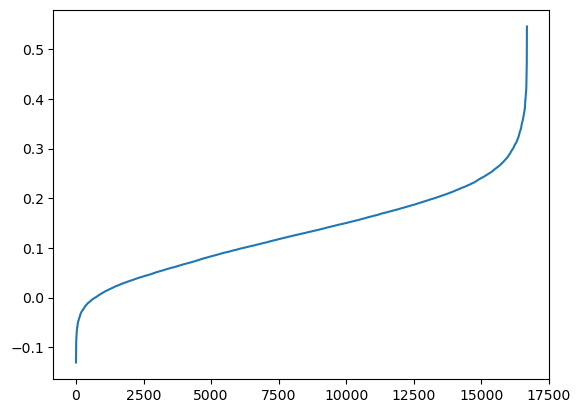

In [36]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def cosine_similarity(a, b):
	return float(np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b))

def best_similarity(req_emb, text_embs):
	return max(cosine_similarity(req_emb, text_emb) for text_emb in text_embs)


def find_poem(request, top_n=10, search_priority=0.5):
	mentioned_parameters = extract_metadata(request)
	standard_params_text = to_standard(mentioned_parameters) + ' '
	print(mentioned_parameters)
	print(standard_params_text)
	req_params_emb = to_embeddings(standard_params_text)
	if len(standard_params_text) < 14: search_priority = 1
	
	req_emb = to_embeddings(request)
	texts_datas = []

	for index, row in df.iterrows():
		text_sim = best_similarity(req_emb, row['text_embedding'])
		#text_sim = cosine_similarity(req_emb, row['text_embedding'])
		req_sim = cosine_similarity(req_params_emb, row['metadata_embedding'])
		
		score = text_sim * search_priority + req_sim * (1-search_priority)
		
		texts_datas.append({'score': score, 'text_sim': text_sim, 'req_sim': req_sim, 
			**{k: v for k, v in row.items() if k != 'metadata_embedding' and k != 'text_embedding'}})
	

	#mean_req_sim = np.mean([x['req_sim'] for x in texts_datas])
	#texts_datas = [x for x in texts_datas if x['req_sim'] > mean_req_sim * 1]
	
	texts_datas.sort(key=lambda x: x['score'])

	plt.plot([x['text_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='text')
	#plt.plot([x['req_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='req')

	return texts_datas[-top_n:][::-1]


#request = 'из окны видны грустные пожелтевшие деревья но все же это моя любимая романтика'
#request = 'научный энтузиазм и борение за оригинальную идею'
#request = 'поднять! сделать! решительность! я! восклецания'
#request = 'дыр бул щыл убеш щур скум вы со бу р л эз'
#request = 'стихотворение, поэзия, поэт, творчество, искусство'
#request = 'деревня родная природа луги поля и просторы'
#request = 'стихотворение, поэзия, поэт, творчество, искусство, Автор: Владимир Маяковский, 3 четверостишья'
#request = 'солнце плещет сквозь ветви дерева'
#request = 'Автор: Александр Крученых'
request = 'снова я напиваюсь'
#request = 'одиночество, когда теряет равновесие твое сознание усталое, одиночество, автор: Иосиф Бродский'

finded = find_poem(request)

for d in finded:
	print(d['text'])
	print({k: v for k, v in d.items() if k != 'text'})
	print('------')

In [32]:
print(cosine_similarity(to_embeddings('В поэзии - пора эстрады, Ее ликующий парад.'), to_embeddings('поэзия и поэт')))
print(cosine_similarity(to_embeddings('Страшней, чем горе, эта скука.'), to_embeddings('поэзия и поэт')))
print(cosine_similarity(to_embeddings('Пронизан солнцем лес насквозь. Лучи стоят столбами пыли.'), to_embeddings('поэзия и поэт')))

ValueError: shapes (1,512) and (1,512) not aligned: 512 (dim 1) != 1 (dim 0)